## ERA5 Mean Turbulent Surface Stress

Data 2020 - downloaded resampled to daily resolution with 1-hourly (res for resampling) [Data Link](https://cds.climate.copernicus.eu/apps/user-apps/app-c3s-daily-era5-statistics?dataset=reanalysis-era5-single-levels&product_type=reanalysis&variable_e5sl=eastward_turbulent_surface_stress&pressure_level_e5sl=-&statistic=daily_mean&year_e5sl=2020&month=01&frequency=1-hourly&time_zone=UTC%2B00:00&grid_e5=0.25/0.25&area.lat:record:list:float=36&area.lat:record:list:float=45&area.lon:record:list:float=-20&area.lon:record:list:float=-5)

Units: $\frac{N}{m^2}$ 

In [151]:
## import packages
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from global_land_mask import globe
import glob
import os
import math

## Functions
- upwelling_index
- land_mask_add

In [2]:
# write as function for calculating the upwelling Index
def upwelling_index(DS, lat, lon, eastward_stress, northward_stress):
    # this function adds the new variables it creates to the input dataset DS
    
    ## Admin
    # to avoid any weird variable attributes appearing where they don't belong
    xr.set_options(keep_attrs=False)
    
    ## 1. Step
    # method based on Oxford Lecture 7 (maybe find better reference)

    # constants
    phi = 1025                                    # density of seawater -> kg/m^3
    omega = 7.2921159e-5                          # angular velocity -> rad/s
    lat_rad = lat * (np.pi / 180)                 # latitude in radians -> rad

    # calculate the Coriolis parameter f
    f = 2 * omega * np.sin(lat_rad.values)        # Coriolis parameter -> rad/s^2
    # create a cube with f -> to fit 
    DS_shape = eastward_stress.shape
    f_cube = np.ones(DS_shape)
    for i in np.arange(0,41):
        f_cube[:,i,:] = f[i]

    # calculate depth integrated Ekman transport    
    DS['ek_trans_u'] = northward_stress / (phi * f_cube)    # m^2/s -> eastward transport (u) is calculated from wind stress in northward direction (v)
    DS.ek_trans_u.attrs.update({"name" : "eastward Ekman transport integrated across Ekman layer (U_Ek)", "ref" : "m^2/s", "ref" : "Lecture 7, Oxford"})
    
    DS['ek_trans_v'] = eastward_stress / (phi * f_cube)    # m^2/s -> northward transport (v) is calculated from wind stress in eastward direction (u)
    DS.ek_trans_v.attrs.update({"name" : "northward Ekman transport integrated across Ekman layer (V_Ek)", "ref" : "m^2/s", "ref" : "Lecture 7, Oxford"})

    # calculate the magnitude of the wind stress (? pretty sure that it is that)
    DS['wind_stress'] = np.hypot(eastward_stress, northward_stress)
    DS.wind_stress.attrs.update({"name" : "combined wind stress", "units" : "N/m^2"})

    ## 2. Step
    # calculate upwelling index (based on Gomez-Gesteira et al. 2006 -> maybe find better/original ref)
   
    # I need the angle of the coast ... as this is a large scale process I will just go with the approximate angle 
    # prehaps refine later

    # constants (?) -> see if I can / need to adjust coast angle
    coast_angle = 0          # assuming 0 degree angle (= 0 rads) as Portugues coast is pretty well aligned with stratigh south-north direction
    perpendicular_angle = 90  # angle of the unitary vector perpendicular to coast pointing landward -› positive UI values mean upwelling favourable conditions
    angle_rad = perpendicular_angle * (np.pi/180)
    
    theta = np.pi/2 + angle_rad
    
    DS['upwelling_index'] = -np.sin(theta) * DS.ek_trans_u + np.cos(theta) * DS.ek_trans_v
    DS.upwelling_index.attrs.update({"name" : "upwelling index", "info" : "positive values upwelling favourable \nassuming Portuguese coast at 0°", "ref" : "Gomez-Gesteira et al. 2006"})


In [3]:
def land_mask_add(DS):
    lon_grid, lat_grid = np.meshgrid(DS.lon.values, DS.lat.values)
    land_mask = globe.is_land(lat_grid, lon_grid)                     # needs input with lat first then lon
    DS['land_mask'] = (('lat', 'lon'), land_mask)
    DS.land_mask.attrs.update({"name" : "land mask", "values" : "0 : land \n1 : ocean", "info" : "uses global_land_mask package"})    

## Load all Data

In [264]:
os.chdir("/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/Surface_stress/")

# load 19th and 20th century data separatly ... to avoid server crashing (and drop empty coordinate "realization"
#TSM_19th = xr.merge([xr.open_dataset(f) for f in glob.glob('Turbulent_mean/*_19*.nc')])
#TSM_19th = TSM_19th.drop_vars(["realization"])
#TSM_20th = xr.merge([xr.open_dataset(f) for f in glob.glob('Turbulent_mean/*_20*.nc')])
#TSM_20th = TSM_20th.drop_vars(["realization"])

# merge datasets
#TSM_all = xr.merge([TSM_19th, TSM_20th])

# save as netcdf 
#TSM_all.to_netcdf("Turbulent_mean/Turbulent_mean_all.nc")

In [265]:
# load data
TSM_all = xr.open_dataset('Turbulent_mean/Turbulent_mean_all.nc')

In [260]:
## resample ERA5 data to same weekly resolution as SST upwelling index (Weekly mean Sat-Fr & time stamp Tue)

# time = 'W-SAT' -> resamples to weekly time res. starting on a Saturday (default is Sunday)
# closed = 'left' -> means [start date, end_date) i.e. start date is included and end_date is exluded in the interval I choose 
# label = 'left' -> the time stamp from the start of the interval is assigned
TSM_weekly_mean = TSM_all.resample(time = 'W-SAT', closed = 'left', label = 'left').mean() 

# change time label ->I want to add 3 days to my time coordinate to move my time stamp from Sat to Tue to match SST upwelling index format
TSM_weekly_mean['time'] = TSM_weekly_mean.time + np.timedelta64(3, 'D')

In [263]:
# save as netcdf 
#TSM_weekly_mean.to_netcdf("Turbulent_mean/Turbulent_mean_weekly.nc")

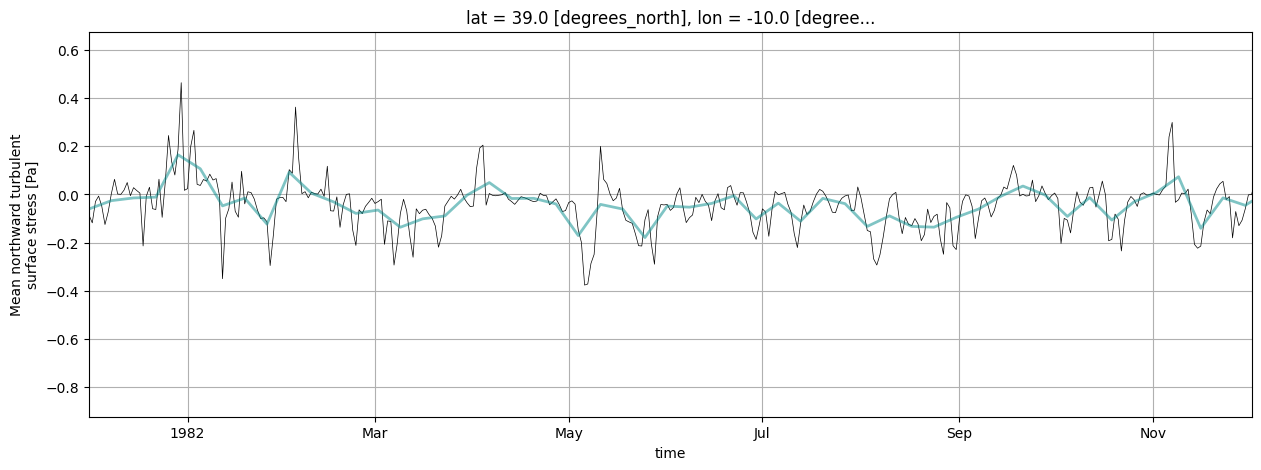

In [262]:
fig = plt.figure(figsize = (15,5))
TSM_all.mntss.sel(lon = -10, lat = 39).plot(color = 'k', linewidth = 0.5, xlim = (TSM_all.time[0], TSM_all.time[366]))
TSM_weekly_mean.mntss.sel(lon = -10, lat = 39).plot(color = 'darkcyan', linewidth = 2, alpha = 0.5)
plt.grid()

## Example 2020

In [5]:
## import data
TSM_20 = xr.merge([xr.open_dataset(f) for f in glob.glob('Turbulent_mean/*_2020_*.nc')])
TSM_20 = TSM_20.drop_vars(["realization"])

In [6]:
land_mask_add(TSM_20)

In [7]:
# starts week on the sunday
TSM_weekly_mean_20 = TSM_20.resample(time = '1W', label = 'left').mean() 
TSM_weekly_std_20 = TSM_20.resample(time = '1W', label = 'left').std() 

In [8]:
TSM_weekly_mean_20

<xarray.Dataset> Size: 1MB
Dimensions:    (lat: 41, lon: 61, time: 53)
Coordinates:
  * lat        (lat) float64 328B 35.0 35.25 35.5 35.75 ... 44.5 44.75 45.0
  * lon        (lon) float64 488B -20.0 -19.75 -19.5 -19.25 ... -5.5 -5.25 -5.0
  * time       (time) datetime64[ns] 424B 2019-12-29 2020-01-05 ... 2020-12-27
Data variables:
    metss      (time, lat, lon) float32 530kB -0.01454 -0.0139 ... 0.3231 0.3236
    mntss      (time, lat, lon) float32 530kB 0.02951 0.02765 ... -0.1822
    land_mask  (time, lat, lon) bool 133kB False False False ... False False
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-04-17T01:07 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

In [9]:
TSM_weekly_std_20

<xarray.Dataset> Size: 2MB
Dimensions:    (lat: 41, lon: 61, time: 53)
Coordinates:
  * lat        (lat) float64 328B 35.0 35.25 35.5 35.75 ... 44.5 44.75 45.0
  * lon        (lon) float64 488B -20.0 -19.75 -19.5 -19.25 ... -5.5 -5.25 -5.0
  * time       (time) datetime64[ns] 424B 2019-12-29 2020-01-05 ... 2020-12-27
Data variables:
    metss      (time, lat, lon) float32 530kB 0.01492 0.01435 ... 0.2061 0.2054
    mntss      (time, lat, lon) float32 530kB 0.021 0.02081 ... 0.08926 0.08706
    land_mask  (time, lat, lon) float64 1MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-04-17T01:07 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

In [37]:
## upwelling index
upwelling_index(TSM_weekly_mean_20, TSM_weekly_mean_20.lat,  TSM_weekly_mean_20.lon, TSM_weekly_mean_20.metss, TSM_weekly_mean_20.mntss)

In [ ]:
### plot 
for i in np.arange(0, len(TSM_weekly_mean_20.time.values), 1):
    fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4, figsize = (21, 4.5), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # set up cartopy
    ax1.set_extent([-20, -5, 45, 35])
    ax1.coastlines()
    gls = ax1.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
    # plot data
    col = np.hypot(TSM_weekly_mean_20.metss.isel(time = i), TSM_weekly_mean_20.mntss.isel(time = i))
    im1 = ax1.quiver(TSM_weekly_mean_20.lon, TSM_weekly_mean_20.lat, TSM_weekly_mean_20.metss.isel(time = i), TSM_weekly_mean_20.mntss.isel(time = i), 
                     col, clim = [0,1], 
                     angles='xy', scale_units='xy', scale = 0.5)
    ax1.set_title('Weekly Mean Wind')
    plt.colorbar(im1, orientation = 'horizontal', label = r'Mean turbulent surface stress [$\frac{N}{m^2}$]', fraction = 0.06)
    qk1 = ax1.quiverkey(im1, 0, 1.08, 0.5, r'0.5 $\frac{N}{m^2}$', labelpos='E')
    
    # set up cartopy
    ax2.set_extent([-20, -5, 45, 35])
    ax2.coastlines()
    gls = ax2.gridlines(draw_labels=True, linewidth = 0.25)
    gls.top_labels = False 
    gls.right_labels = False
    # plot std as function the length of the hypothenuse -> combine the vectors
    dat = np.hypot(TSM_weekly_std_20.metss.isel(time = i), TSM_weekly_std_20.mntss.isel(time = i))
    im2 = ax2.contourf(TSM_weekly_std_20.lon, TSM_weekly_std_20.lat, dat, transform = ccrs.PlateCarree(), levels = np.arange(0, 1.05, 0.05), extend = 'both')
    ax2.set_title('Weekly Standard Deviataion')
    #ax2.quiver(TSM_weekly_std_20.lon, TSM_weekly_std_20.lat, TSM_weekly_std_20.metss.isel(time = i), TSM_weekly_std_20.mntss.isel(time = i)) # if I wanted to preserver information on direction I'd have to plot this
    plt.colorbar(im2, orientation = 'horizontal', label = r'STD turbulent surface stress [$\frac{N}{m^2}$]', fraction = 0.06, ticks = np.arange(0, 1.1, 0.1))

    # set up cartopy
    ax3.set_extent([-20, -5, 45, 35])
    ax3.coastlines()
    gls = ax3.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
    # plot data
    im3 = ax3.contourf(TSM_weekly_mean_20.lon, TSM_weekly_mean_20.lat, TSM_weekly_mean_20.upwelling_index.isel(time = i).where(TSM_weekly_mean_20.land_mask.isel(time=i) == False), 
                       transform = ccrs.PlateCarree(), levels = np.arange(-3, 3.5, 0.5), extend = 'both')
    ax3.set_title('Upwelling Index')
    plt.colorbar(im3, orientation = 'horizontal', label = r'Upwelling Index', fraction = 0.06, ticks = np.arange(-3, 4, 1))

    # set up cartopy
    ax4.set_extent([-20, -5, 45, 35])
    ax4.coastlines()
    gls = ax4.gridlines(draw_labels=True, linewidth = 0.5)
    gls.top_labels = False 
    gls.right_labels = False
    # plot data
    im4 = ax4.contourf(TSM_weekly_mean_20.lon, TSM_weekly_mean_20.lat, TSM_weekly_mean_20.ek_trans_u.isel(time = i).where(TSM_weekly_mean_20.land_mask.isel(time=i) == False), 
                       transform = ccrs.PlateCarree(), levels = np.arange(-3, 3.5, 0.5), extend = 'both')
    ax4.set_title('Zonal component of Ekman transport')
    plt.colorbar(im4, orientation = 'horizontal', label = r'Zonal (u) component of Ekman transport [$\frac{m^2}{s}$]', fraction = 0.06, ticks = np.arange(-3, 4, 1))
    
    fig.suptitle(f'{str(TSM_weekly_mean_20.time[i].values)[0:10]}', fontsize = 17);
    #fig.tight_layout()
